## Буйновский Андрей Васильевич

Задание:
* Сделать проект по классификации наличия святого Георгия на изображении. В папке есть два файла со списком картинок: Георгиев и не Георгиев. Нужно сделать jupyter notebook, в котором будет обучаться модель классификации Георгиев и не Георгиев. Скачать файлы можно при помощи wget: `wget --random-wait -i filename.txt`. Ссылка на папку для копирования: https://drive.google.com/drive/folders/1hXAjwpBj6shfWd1taWMFpSqelFCzi6KJ?usp=sharing .


Для решения данной задачи я взял за основу свою домашнюю работу по классификации изображений (Deep Learning School, делал осенью 2020 [Simpson's classification](https://github.com/AndreyBuynov/DeepLearningSchool/blob/main/AndreyBuynovskiy_kaggle_simpsons.ipynb)).

Датасет был скачан в гугл колаб по разным папкам. Для тестовой папки взял наугад 5 и 4 картинок из папок Георгии или не Георгии.

В созданном даталоадере происходит аугментация подаваемых изображений (простые отражения по вертикали и горизонтали), а так же преобразование черно-белых картинок к цветным чтоб у всех была одинаковая размерность.

Сеть используется в качестве бэкбоуна резнет 18 с добавлением полносвязных слоев от Алекснет и заморозки первых входных слоев. Для обучения остались добавленные слои от алекснет и последние слои от резнет.

In [1]:
import torch
import numpy as np

torch.cuda.is_available()

True

In [2]:
import PIL
import pandas as pd

Преобразую список ссылок на картинки в csv в список ссылок в текстовом файле и затем скачаю их в разные папки - с Георгием и без соответственно.

In [3]:
georges = pd.read_csv('/content/georges.csv', header = None)
nongeorges = pd.read_csv('/content/non_georges.csv', header = None)

In [36]:
len(georges), len(nongeorges)

(2681, 3366)

Количество разных классов не сильно отличается, поэтому балансировать дополнительно не буду

In [32]:
def make_list_pict(df, file_name):
    file_n = '/content/' + file_name
    new_file = open(file_n, 'a')    
    for i in range(len(df)):
        new_file.writelines(df.loc[i].item() + '\n')
    new_file.close()

In [33]:
make_list_pict(georges, 'georges.txt')
make_list_pict(nongeorges, 'nongeorges.txt')

In [ ]:
!wget -P /content/georges -i /content/georges.txt

In [ ]:
!wget -P /content/nongeorges -i /content/nongeorges.txt

In [37]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [45]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Создаю свой даталоадер для подачи картинок в процессе обучения модели

In [61]:
class Georges(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image.convert('RGB') #добавил конвертацию в RGB, потому что попадались черно-булые картинки
  
    def __getitem__(self, index):
        
        # здесь преобразуем картинки для обучения
        if self.mode == 'train':
            transform = transforms.RandomApply(nn.ModuleList([
                transforms.RandomHorizontalFlip(p=0.5),
                #transforms.RandomRotation(degrees=10),
                transforms.RandomVerticalFlip(p=0.5)
            ]), p=1)
            
        # здесь нормализуем и переводим в тензор
        normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        
        x = self.load_sample(self.files[index])
        if self.mode == 'train':
          x = transform(x)

        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = normalize(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [40]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [41]:
TRAIN_DIR = Path('/content/train')
TEST_DIR = Path('/content/test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [42]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.30, \
                                          stratify=train_val_labels)

In [43]:
len(train_val_files)

5692

In [44]:
# проверял количество классов
len(np.unique(train_val_labels))

2

In [62]:
val_dataset = Georges(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

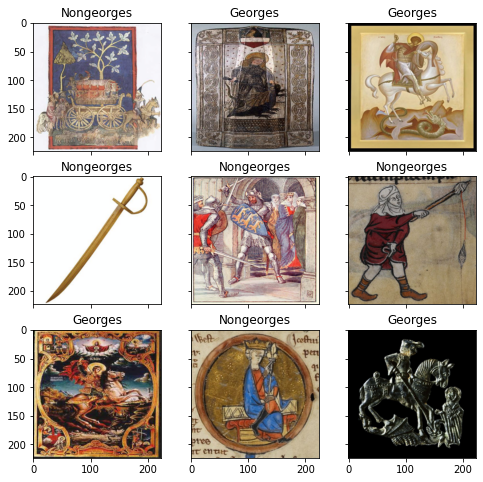

In [47]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети

Для обучения использую resnet18 с добавления последних слоев из алекснет (не полностью, а урезал исходник от алекснет) и заморозки первых входных слоев. Для обучения остались добавленные слои от алекснет и последние слои от резнет.


In [66]:
from torchvision import models
resnet_model = models.resnet18(pretrained=True)

In [67]:
#замораживаю параметры, оставляю для обучения только крайние слои
for i, child in enumerate(resnet_model.children()):
    for param in child.parameters():
        param.requires_grad = False
        if i == 9 or i == 7 or i == 6:
            param.requires_grad = True

#последний полносвязный заменен на линейные выходные слои из алекснет (не все, экспериментировал)
resnet_model.fc = nn.Sequential(
    #nn.Dropout(p=0.5, inplace=False),
    #nn.Linear(in_features=512, out_features=512, bias=True),
    #nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=512, out_features=512, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=512, out_features=2, bias=True))

In [68]:
my_model = resnet_model.to(DEVICE)

In [52]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [53]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [54]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        #добавил в оптимизатор параметр lr = 0.0001
        opt = torch.optim.Adam(model.parameters(), lr = 0.0001)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [55]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [56]:
n_classes = len(np.unique(train_val_labels))

# использовал переменную simple_cnn чтоб дальше не править код (для удобства)
#simple_cnn = my_model.to(DEVICE) #SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
#print(simple_cnn)

we will classify :2


Запустим обучение сети.

In [63]:
if val_dataset is None:
    val_dataset = Georges(val_files, mode='val')
    
train_dataset = Georges(train_files, mode='train')

In [70]:
history = train(train_dataset, val_dataset, model=my_model, epochs=10, batch_size=128)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.467667115201433


epoch:  10%|█         | 1/10 [01:45<15:46, 105.12s/it]


Epoch 001 train_loss: 0.4677     val_loss 0.3308 train_acc 0.7718 val_acc 0.8484
loss 0.27464398310845156


epoch:  20%|██        | 2/10 [03:29<13:59, 104.88s/it]


Epoch 002 train_loss: 0.2746     val_loss 0.2773 train_acc 0.8883 val_acc 0.8858
loss 0.24831220256276879


epoch:  30%|███       | 3/10 [05:13<12:12, 104.62s/it]


Epoch 003 train_loss: 0.2483     val_loss 0.3233 train_acc 0.8923 val_acc 0.8607
loss 0.16639008118684992


epoch:  40%|████      | 4/10 [06:57<10:26, 104.47s/it]


Epoch 004 train_loss: 0.1664     val_loss 0.2712 train_acc 0.9347 val_acc 0.8952
loss 0.11695819321167038


epoch:  50%|█████     | 5/10 [08:41<08:41, 104.32s/it]


Epoch 005 train_loss: 0.1170     val_loss 0.4241 train_acc 0.9578 val_acc 0.8372
loss 0.10643868048836189


epoch:  60%|██████    | 6/10 [10:25<06:57, 104.30s/it]


Epoch 006 train_loss: 0.1064     val_loss 0.4786 train_acc 0.9603 val_acc 0.8361
loss 0.10738217884517577


epoch:  70%|███████   | 7/10 [12:11<05:14, 104.78s/it]


Epoch 007 train_loss: 0.1074     val_loss 0.2837 train_acc 0.9591 val_acc 0.9040
loss 0.09124507080299787


epoch:  80%|████████  | 8/10 [13:55<03:29, 104.55s/it]


Epoch 008 train_loss: 0.0912     val_loss 0.2742 train_acc 0.9649 val_acc 0.9122
loss 0.07769402843454935


epoch:  90%|█████████ | 9/10 [15:39<01:44, 104.43s/it]


Epoch 009 train_loss: 0.0777     val_loss 0.2686 train_acc 0.9709 val_acc 0.9098
loss 0.053064726352931024


epoch: 100%|██████████| 10/10 [17:23<00:00, 104.38s/it]


Epoch 010 train_loss: 0.0531     val_loss 0.3504 train_acc 0.9809 val_acc 0.9075


Построим кривые обучения

In [71]:
loss, acc, val_loss, val_acc = zip(*history)

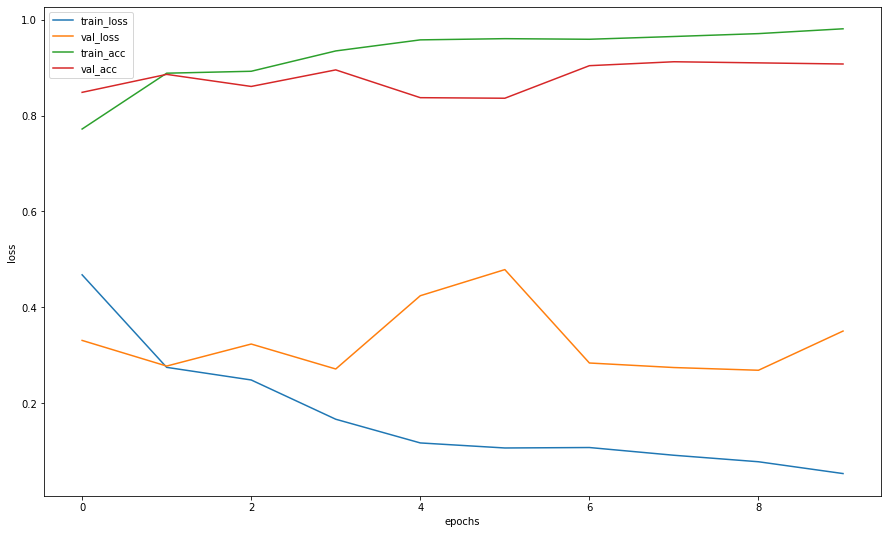

In [72]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.plot(acc, label = "train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [73]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [74]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(my_model, ex_img.unsqueeze(0))

In [75]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(my_model, imgs)

In [76]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [77]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [78]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred.tolist(), average='weighted')


0.7

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах.

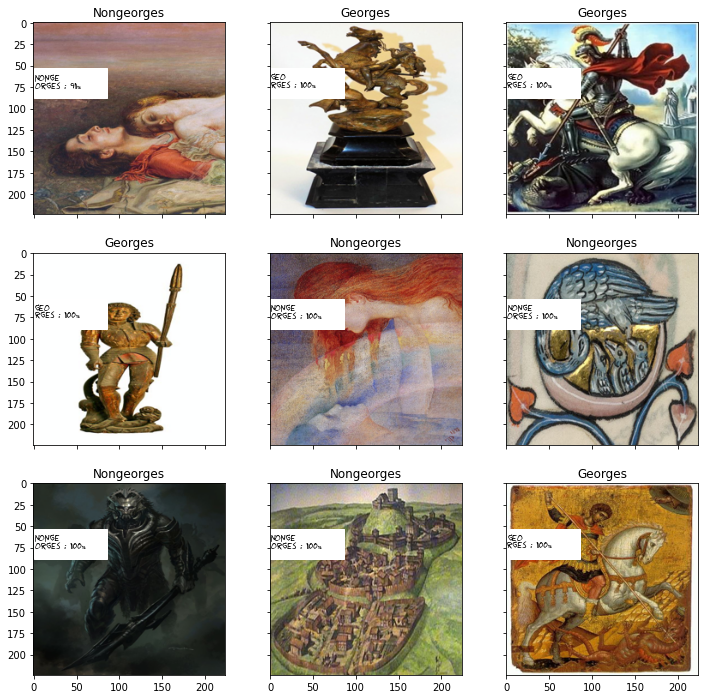

In [79]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

По картинкам вроде бы все складывается красиво и правильно, но на валидационных данных получилось не очень качественно. Возможно поможет увеличение датасета путем аугментации или добавить количество эпох. Можно экспериментировать.